In [260]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from gym.envs.toy_text.blackjack import BlackjackEnv, sum_hand

class CustomBlackjackEnv(BlackjackEnv):
    """
    A custom Blackjack environment that extends the Gym Blackjack environment to include
    custom functionalities such as resetting to a specific observation state and rendering
    with different modes. Subclassing the original BlackjackEnv was needed in order to implement
    all of the Monte Carlo methods from the Sutton & Barto book with one class.

    Attributes:
        x (int): The player (agent) sum value considered in the observation space.
        y (int): The dealer's showing card value considered in the observation space.
        z (int): The binary flag indicating the presence of a usable ace for the player in the observation space.
        state_space (list of tuples): The set of all possible states (player sum, dealer card, usable ace flag).
        render_mode (str): The mode used for rendering. Supported modes include 'human' for console output
                           and 'rgb_array' for graphical rendering (not implemented).

    Parameters:
        natural (bool): Flag to determine whether natural blackjack pays out 1.5x. Defaults to False.
        sab (bool): Flag for following the "start-at-beginning" rule from Sutton and Barto's book. Defaults to True.
        render_mode (str): The rendering mode. Defaults to 'human'.

    GPT:
        GPT-4 was used to generate the docstrings in this class.
    """

    def __init__(self, natural=False, sab=True, render_mode="human"):
        super().__init__(natural=natural, sab=sab)
        self.x = self.observation_space[0].n
        self.y = self.observation_space[1].n
        self.z = self.observation_space[2].n
        self.state_space = [(a, b, c) for a in range(2, self.x) for b in range(1, self.y) for c in range(self.z)]
        self.render_mode = render_mode

    def render(self, mode='human', show_dealer_hand=False):
        """
        Renders the current state of the environment according to the specified mode.

        Parameters:
            mode (str): The rendering mode. Supported values are 'human' and 'rgb_array'.
                        The 'rgb_array' mode is not implemented and will print a placeholder message.
        """
        if mode != self.render_mode:
            print(f"Rendering mode set to {self.render_mode}, but trying to render with {mode}.")
            return

        if mode == 'human':
            player_hand_str = [self.card_to_str(card) for card in self.player]
            dealer_hand_str = [self.card_to_str(card) for card in self.dealer]
            print(f"Player's hand: {player_hand_str} with sum: {sum_hand(self.player)}")
            print(f"Dealer's showing card: {self.card_to_str(self.dealer[0])}")
            if show_dealer_hand:
                print(f"Dealer's hand: {dealer_hand_str} with sum: {sum_hand(self.dealer)}")
        elif mode == 'rgb_array':
            print("Graphical rendering not implemented. TODO: Implement graphical rendering for next semester.")

    def card_to_str(self, card):
        """
        Converts a card number to its string representation.

        Parameters:
            card (int): The card number.

        Returns:
            str: The string representation of the card.
        """
        if card == 1:
            return 'Ace'
        elif card in [11, 12, 13]:
            return {11: 'Jack', 12: 'Queen', 13: 'King'}[card]
        else:
            return str(card)

    def custom_reset(self, observation=None):
        """
        Resets the environment to a specific state based on the provided observation.

        Parameters:
            observation (tuple): A tuple containing the player total, dealer showing card,
                                  and usable ace flag to reset the state to. If None, the environment
                                  is reset to a random state.

        Returns:
            tuple: The initial observation of the reset environment.
        """
        super().reset()
        if observation:
            player_total, dealer_showing, usable_ace = observation
            if usable_ace:
                self.player = [6, 1] if player_total == 17 else [player_total - 11, 1]
            else:
                self.player = [player_total - 10, 10]
            self.dealer = [dealer_showing, np.random.randint(1, 11)]
        return self._get_obs()

env = CustomBlackjackEnv()

# Demonstrate usage.
print(f"env.reset() = {env.reset()}")
env.render()


env.reset() = (18, 7, False)
Player's hand: ['8', '10'] with sum: 18
Dealer's showing card: 7


In [150]:
starting_state = (12, 3, False)
print(f"{env.custom_reset(observation=starting_state) = } \n")
env.render()
print()

print(f"{env.step(1) = } \n")
env.render()

env.custom_reset(observation=starting_state) = (12, 3, False) 

Player's hand: ['2', '10'] with sum: 12
Dealer's showing card: 3

env.step(1) = ((22, 3, False), -1.0, True, {}) 

Player's hand: ['2', '10', '10'] with sum: 22
Dealer's showing card: 3


In [264]:
# Define a class for tabular reinforcement learning policies.
# Policies can be defined as functions or as tables.
class TabularPolicy:
    """
    A class to represent tabular reinforcement learning policies.

    This class provides a flexible representation of a policy, which can be defined either as a function
    that maps states to actions, or as a table that provides action probabilities for each state. It allows
    for the application of epsilon-greedy strategies for action selection and supports updating of policy
    tables.

    Attributes:
        action_space (list or gym.spaces.Space): The space of possible actions, typically provided by
                                                 an environment's action_space.
        state_space (list): The space of possible states. This can be a list of states or any iterable
                            that enumerates all possible states in the environment.
        epsilon (float): The probability of choosing a random action in an epsilon-greedy policy. This
                         facilitates exploration.
        policy_table (dict, optional): A mapping from states (or state-action pairs) to action probabilities
                                       or values. If provided, it is used for determining the policy's actions.
        policy_function (callable, optional): A function that takes a state (and optionally an action) as
                                              input and returns an action or action probability. If provided,
                                              it is used for determining the policy's actions.

    Methods:
        __call__(state, action=None):
            Determines the action to take for a given state. If an action is not specified, it selects an
            action based on the policy function or policy table. If an action is specified, it returns the
            action probability or value from the policy table or function.

        set_state_action_policy(state, action, values):
            Updates the policy table with new values for a given state-action pair.

        set_state_policy(state, values):
            Updates the policy table with new values for all actions in a given state.

    Example:
        >>> action_space = [0, 1]  # For a simple binary action space
        >>> state_space = range(5)  # For states 0 through 4
        >>> def policy_fn(state):
        ...     return 0 if state < 3 else 1
        >>> policy = TabularPolicy(action_space, state_space, policy_function=policy_fn)
        >>> print(policy(2))
        0
        >>> print(policy(3))
        1

    Note:
        - The policy can operate in two modes: table-based or function-based. If both a policy table
          and a policy function are provided, the function takes precedence when determining actions.
        - When using the policy table for action selection, it assumes a probability distribution over
          the actions for each state and selects an action based on these probabilities.
    """
    def __init__(self, action_space, state_space, policy_table=None, policy_function=None, epsilon=0.1):
        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = epsilon
        self.policy_table = policy_table
        self.policy_function = policy_function

    def __call__(self, state, action=None):
        if not action:
            if self.policy_function:
                return self.policy_function(state)
            elif self.policy_table:
                return np.random.choice(self.action_space, p=self.policy_table[state])
            else:
                return np.random.choice(self.action_space)
        else:
            if self.policy_function:
                return self.policy_function(state, action)
            elif self.policy_table:
                return self.policy_table[(state, action)]
            else:
                return np.random.choice(self.action_space)

    def set_state_action_policy(self, state, action, values):
        self.policy_table[(state, action)] = values

    def set_state_policy(self, state, values):
        self.policy_table[state] = values

In [265]:

random_policy = TabularPolicy([0, 1], env.state_space)
starting_state = (12, 3, False)
print(f"{env.custom_reset(observation=starting_state) = } \n")
env.render()
print()

action = random_policy(starting_state)

print(f"{env.step(action) = } \n")
env.render()
print()


env.custom_reset(observation=starting_state) = (12, 3, False) 

Player's hand: ['2', '10'] with sum: 12
Dealer's showing card: 3

env.step(action) = ((12, 3, False), -1.0, True, {}) 

Player's hand: ['2', '10'] with sum: 12
Dealer's showing card: 3



In [266]:

def generate_episode(env, policy, starting_state=None, starting_action=None):
    """
    Generates an episode by simulating interactions with the environment based on a given policy.

    This function iterates through the steps of an episode, beginning with an optional starting state
    and/or action, and continues until the environment returns a termination or truncation signal. At each
    step, it records the state, action taken, and reward received, appending these details to the episode
    history. The episode ends when the environment indicates termination (the episode naturally concludes)
    or truncation (the episode reaches a predefined limit, such as a maximum number of steps).

    Parameters:
        env: The environment object compliant with the OpenAI Gym interface. This environment should
             have a `custom_reset` method that optionally takes an observation as an argument to set
             the starting state of the environment, and a `step` method that takes an action and returns
             the next state, reward, and termination or truncation flags.
        policy: A dictionary mapping from state to action or a function that takes a state as input and
                returns an action. The policy dictates the action to be taken in each state.
        starting_state (optional): The initial state from which to start the episode. If not provided,
                                   the environment's reset method is used to obtain the initial state.
        starting_action (optional): The first action to take in the episode. If not specified, the action
                                    is selected based on the provided policy.

    Returns:
        episode: A list of tuples, where each tuple contains (state, action, reward) representing the
                sequence of steps taken in the episode. Each tuple represents a step in the environment,
                capturing the state before the action, the action taken, and the immediate reward received.
                Note, if episode[t] = (state, action, reward), then state is S_t, action is A_t, and reward
                is R_{t+1}. This will be the case for all t in [0, T-1], where T is the length of the episode.

    Example:
        >>> env = CustomBlackjackEnv()
        >>> policy_function = lambda state : 0 # Always stick
        >>> policy = TabularPolicy([0, 1], env.state_space, policy_function=policy_function)
        >>> episode = generate_episode(env, policy)
        >>> print(episode[0])  # Prints the first step of the episode

    GPT:
        GPT-4 was used to generate the docstrings in this function.
    """
    episode = []
    state = env.custom_reset(observation=starting_state)
    while True:
        action = starting_action if starting_action else policy(state)
        next_state, reward, terminated, truncated = env.step(action)
        episode.append((state, action, reward))
        if terminated or truncated:
            break
        state = next_state
    return episode

def win_percentage(env, policy, num_games=10_000):
    """
    Calculates the win percentage of a given policy over a specified number of games in a given environment.

    This function simulates a series of episodes (games) in the environment using the specified policy.
    It then calculates the percentage of those games that resulted in a win. A win is determined by
    examining the reward of the first step in each episode, assuming that the reward signal at the
    end of the episode accurately reflects winning (reward = 1) or not winning (reward != 1).

    Parameters:
        env (gym.Env): The environment in which to simulate the episodes. The environment should be
                       compatible with the OpenAI Gym interface and support the generation of episodes
                       via the specified policy.
        policy (function or dict): The policy to be evaluated. It can be a function that takes a state
                                   as input and returns an action, or a dictionary mapping states to actions.
                                   The policy dictates the actions to be taken by the agent in each state
                                   of the environment.
        num_games (int, optional): The number of episodes to simulate for evaluating the policy. Defaults
                                   to 10,000.

    Returns:
        float: The win percentage of the policy over the specified number of episodes, expressed as
               a percentage (0 to 100).

    Example:
        >>> env = gym.make('Blackjack-v0')
        >>> policy_function = lambda state: 0 if state[0] > 18 else 1 # Stick if sum of player's cards is 19 or more
        >>> policy = TabularPolicy([0, 1], env.state_space, policy_function=policy_function)
        >>> print(win_percentage(env, policy, num_games=1000))
        43.2

    Note:
        - The function assumes that a reward of 1 at the end of an episode signifies a win, which is
          typical for environments like Blackjack but may need adjustment for other types of environments
          or reward structures.
        - This function does not account for draws or ties; any outcome that does not result in a reward
          of 1 is considered not a win.

    GPT:
        GPT-4 was used to generate the docstrings in this class.
    """
    wins = 0
    for _ in range(num_games):
        episode = generate_episode(env, policy)
        if episode[0][-1] == 1:
            wins += 1
    return wins / num_games * 100


In [267]:
# "What does a episode look like?"
episode = generate_episode(env, random_policy)
for state, action, reward in episode:
    env.render()
    print(f"s = {state}, a = {action}, r = {reward} \n")
env.render()
print()

# "What is the win percentage of the random policy?"
print(f"Win percentage of random policy: {win_percentage(env, random_policy)}%")

Player's hand: ['3', '3', '9', '10'] with sum: 25
Dealer's showing card: 10
s = (6, 10, False), a = 1, r = 0.0 

Player's hand: ['3', '3', '9', '10'] with sum: 25
Dealer's showing card: 10
s = (15, 10, False), a = 1, r = -1.0 

Player's hand: ['3', '3', '9', '10'] with sum: 25
Dealer's showing card: 10

Win percentage of random policy: 18.86%


In [268]:
def first_visit_monte_carlo(env, policy, gamma=1.0, num_episodes=5_000):
    """
    Estimates the value function V for a given policy using the First-Visit Monte Carlo method.

    This function iteratively generates episodes according to the given policy and updates the
    value function estimate for each state based on the returns following the first visit to that state.
    It operates under the assumption of episodic tasks, meaning each episode eventually reaches a
    terminal state.

    Parameters:
        env: The environment object that adheres to the OpenAI Gym interface. The environment should
             have a `state_space` attribute listing all possible states and support the generation of
             episodes via the `generate_episode` function.
        policy: A policy under which episodes are generated, defined as a mapping from states to actions.
                The policy dictates the behavior of the agent in the environment and is assumed to be fixed
                and deterministic in this context.
        gamma (float): The discount factor, specifying the importance of future rewards. It must be a value
                       between 0 and 1, inclusive. A value of 0 means "only consider immediate rewards", while
                       1 means "consider future rewards just as important as immediate ones".
        num_episodes (int): The number of episodes to generate for estimating the value function. More episodes
                            typically lead to a more accurate estimate, at the cost of increased computation.

    Returns:
        V (dict): A dictionary mapping states to their estimated values under the given policy. Represents the
                  value function V(s) ≈ v_π(s), which estimates the expected return from each state s under the
                  policy π.

    Example:
        >>> env = CustomBlackjackEnv()
        >>> policy_function = lambda state: 0 if state[0] > 18 else 1 # Stick if sum of player's cards is 19 or more
        >>> policy = TabularPolicy([0, 1], env.state_space, policy_function=policy_function)
        >>> V = first_visit_monte_carlo(env, policy)
        >>> print(V[(13, 2, False)])  # Example: estimated value of having 13, dealer showing 2, no usable ace

    GPT:
        GPT-4 was used to generate the docstrings in this function.
    """
    # Initialize the value function randomly.
    V = {state: np.random.rand() for state in env.state_space}

    # Initialize the Reward variable with empty lists for each state.
    R = {state: [] for state in env.state_space}

    for _ in range(num_episodes):
        episode = generate_episode(env, policy)
        states, actions, rewards = zip(*episode)

        # Initialize the expected return.
        G = 0.0

        # Get the terminal time state T.
        T = len(episode)

        # Loop backwards through the episode.
        for t in range(T-1, -1, -1):
            # Update return
            G = gamma * G + rewards[t]

            # If the state at time t is not in the list of states before t
            if states[t] not in states[:t]:
                # Append return to state's returns list so that we can calculate a new average of
                # returns for that state.
                R[states[t]].append(G)

                # Update state's value as average of returns.  Note this could be more efficiently following
                # the same pattern as with the Bandit problem from Sutton & Barto Chapter 2.
                V[states[t]] = np.mean(R[states[t]])
    return V


In [269]:
# Compute the value function for the random policy.
V = first_visit_monte_carlo(env, random_policy, num_episodes=5_000)

# Print the value function for the random policy.
print("--------------- Value Function for Random Policy ----------------")
i = 0
for state, value in V.items():
    if i < 10:
        print(f"V[{state}] = {V[state]}")
    else:
        break
    i += 1

--------------- Value Function for Random Policy ----------------
V[(2, 1, 0)] = 0.07215274498212865
V[(2, 1, 1)] = 0.6871743773661977
V[(2, 2, 0)] = 0.18209284518320967
V[(2, 2, 1)] = 0.3095196404810946
V[(2, 3, 0)] = 0.5576885246033163
V[(2, 3, 1)] = 0.4430915171696628
V[(2, 4, 0)] = 0.4579983698888751
V[(2, 4, 1)] = 0.8720327995913733
V[(2, 5, 0)] = 0.8594016691484438
V[(2, 5, 1)] = 0.8915343908608424


In [272]:

def prepare_data_for_plot(V, usable_ace):
    player_sums = sorted(set(key[0] for key in V.keys() if 12 <= key[0] <= 21 and key[2] == usable_ace))
    dealer_showing = sorted(set(key[1] for key in V.keys() if key[2] == usable_ace))
    Y, X = np.meshgrid(player_sums, dealer_showing)
    Z = np.zeros_like(X, dtype=float)

    # Outer loop for dealer's card.
    for i, dealer_card in enumerate(dealer_showing):
        # Inner loop for player's sum.
        for j, player_sum in enumerate(player_sums):
            # Assign values accordingly.
            Z[i, j] = V.get((player_sum, dealer_card, usable_ace), np.nan)

    return X, Y, Z

def plot_value_function(V, usable_ace, title):
    X, Y, Z = prepare_data_for_plot(V, usable_ace)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Dealer\'s Showing Card')
    ax.set_ylabel('Player\'s Current Sum')
    ax.set_zlabel('Value')
    ax.set_title(title)
    fig.colorbar(surf)
    plt.show()

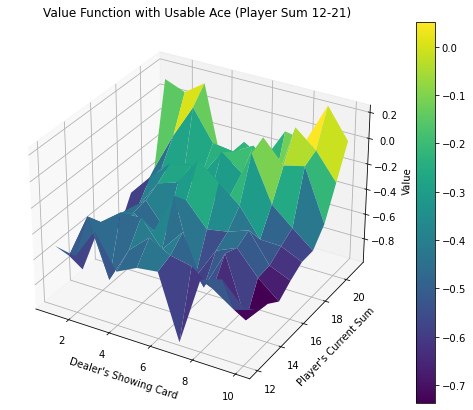

In [274]:
# Compute the value function for the random policy with 5_000 episodes.
V = first_visit_monte_carlo(env, random_policy, num_episodes=5_000)

# Plot for states without a usable ace, with axes switched
plot_value_function(V, 0, 'Value Function with Usable Ace (Player Sum 12-21)')

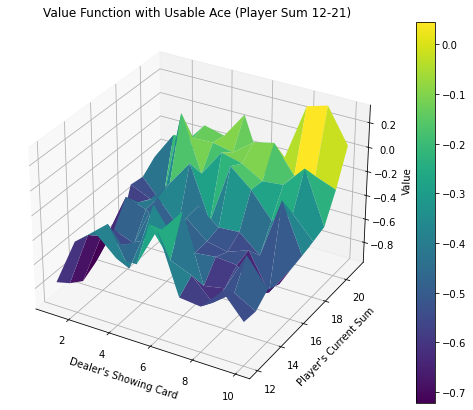

In [275]:
# Compute the value function for the random policy with 5_000 episodes.
V = first_visit_monte_carlo(env, random_policy, num_episodes=5_000)

# Plot for states with a usable ace, with axes switched
plot_value_function(V, 0, 'Value Function with Usable Ace (Player Sum 12-21)')

In [276]:
# Sutton & Barto BlackJack policy from the Monte Carlo Chapter.
# sab_policy = {state: int(state[0] < 20) for state in env.state_space}
def sab_policy_function(state):
    return int(state[0] < 20)

sab_policy = TabularPolicy([0, 1], env.state_space, policy_function=sab_policy_function)

# Compute the value function for the Sutton & Barto policy.
V = first_visit_monte_carlo(env, sab_policy)

# Print the value function for the Sutton & Barto policy.
print("------------- Value Function for Sutton & Barto Policy ----------------")
i = 0
for state, value in V.items():
    if i < 10:
        print(f"V[{state}] = {V[state]}")
    else:
        break
    i += 1

------------- Value Function for Sutton & Barto Policy ----------------
V[(2, 1, 0)] = 0.707088610678581
V[(2, 1, 1)] = 0.815449598600092
V[(2, 2, 0)] = 0.23859325821876554
V[(2, 2, 1)] = 0.626502124568583
V[(2, 3, 0)] = 0.6728821103612677
V[(2, 3, 1)] = 0.8440357390025587
V[(2, 4, 0)] = 0.9519779642283454
V[(2, 4, 1)] = 0.4159828626318144
V[(2, 5, 0)] = 0.2810669327158397
V[(2, 5, 1)] = 0.9233770841603159


In [277]:
# Compute the value function for the Sutton & Barto policy with 500_000 iterations.
# Note, this will take a few minutes..... Using Chapter 2 for inspiration, can you make this faster?
V = first_visit_monte_carlo(env, sab_policy, num_episodes=30_000)

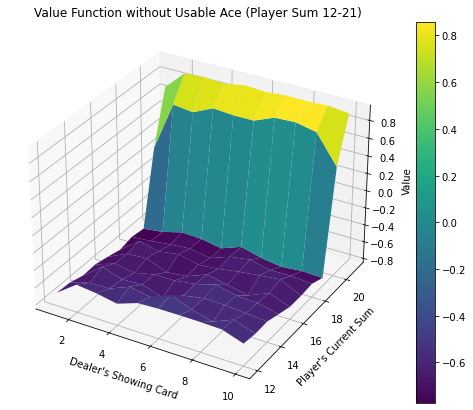

In [278]:
# Plot for states without a usable ace.
plot_value_function(V, 0, 'Value Function without Usable Ace (Player Sum 12-21)')

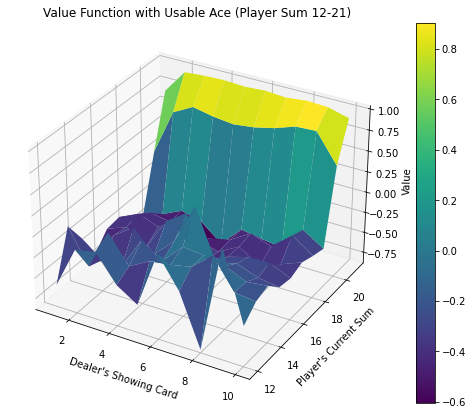

In [279]:
# Plot for states with a usable ace.
plot_value_function(V, 1, 'Value Function with Usable Ace (Player Sum 12-21)')

In [280]:
def prepare_data_for_plot(V, usable_ace):
    """
    Prepares data for plotting the value function V as a surface plot.

    This function extracts and organizes the necessary components (X, Y, Z) for plotting
    from the value function V, considering whether an ace is usable in the player's hand.

    Parameters:
        V (dict): A dictionary representing the value function V(s), where keys are state tuples
                  (player_sum, dealer_showing, usable_ace) and values are the estimated values.
        usable_ace (bool): A flag indicating whether to filter the states for those with a usable
                           ace (True) or without a usable ace (False).

    Returns:
        tuple: A tuple containing three numpy arrays (X, Y, Z) representing the meshgrid for plotting
               and the corresponding Z values for each (x, y) point on the meshgrid. X represents
               dealer's showing card, Y represents player's current sum, and Z represents the value
               of each state.

    Example:
        >>> V = {(18, 2, False): -0.1, (18, 2, True): 0.0, ...}
        >>> X, Y, Z = prepare_data_for_plot(V, usable_ace=False)
        >>> print(X.shape, Y.shape, Z.shape)
        (10, 10) (10, 10) (10, 10)
    """
    player_sums = sorted(set(key[0] for key in V.keys() if 12 <= key[0] <= 21 and key[2] == usable_ace))
    dealer_showing = sorted(set(key[1] for key in V.keys() if key[2] == usable_ace))
    Y, X = np.meshgrid(player_sums, dealer_showing)
    Z = np.zeros_like(X, dtype=float)

    for i, dealer_card in enumerate(dealer_showing):
        for j, player_sum in enumerate(player_sums):
            Z[i, j] = V.get((player_sum, dealer_card, usable_ace), np.nan)

    return X, Y, Z

def plot_value_function_subplot(V_first, V_second, title_first, title_second):
    """
    Plots two sets of value functions as surface plots in a 2x2 subplot layout.

    Each set of value functions is plotted twice: once considering states with a usable ace and
    once with states without a usable ace. This allows for visual comparison between different
    estimations of the value function and the impact of having a usable ace.

    Parameters:
        V_first (dict): The first value function to plot, where keys are state tuples
                        (player_sum, dealer_showing, usable_ace) and values are the estimated values.
        V_second (dict): The second value function to plot, structured like V_first.
        title_first (str): The title for subplots corresponding to V_first.
        title_second (str): The title for subplots corresponding to V_second.

    Returns:
        None: This function plots the value functions directly and does not return any value.

    Example:
        >>> V_first = {(18, 2, False): -0.1, (18, 2, True): 0.0, ...}
        >>> V_second = {(18, 2, False): -0.05, (18, 2, True): 0.05, ...}
        >>> plot_value_function_subplot(V_first, V_second, "Before Training", "After Training")
    """
    fig = plt.figure(figsize=(20, 14))

    for i, usable_ace in enumerate([0, 1]):
        X, Y, Z_first = prepare_data_for_plot(V_first, usable_ace)
        ax = fig.add_subplot(2, 2, i + 1, projection='3d')
        surf = ax.plot_surface(X, Y, Z_first, cmap='viridis', edgecolor='none')
        ax.set_xlabel("Dealer's Showing Card")
        ax.set_ylabel("Player's Current Sum")
        ax.set_zlabel('Value')
        ax.set_title(f"{title_first} - Usable Ace: {bool(usable_ace)}")
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

        X, Y, Z_second = prepare_data_for_plot(V_second, usable_ace)
        ax = fig.add_subplot(2, 2, i + 3, projection='3d')
        surf = ax.plot_surface(X, Y, Z_second, cmap='viridis', edgecolor='none')
        ax.set_xlabel("Dealer's Showing Card")
        ax.set_ylabel("Player's Current Sum")
        ax.set_zlabel('Value')
        ax.set_title(f"{title_second} - Usable Ace: {bool(usable_ace)}")
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.show()

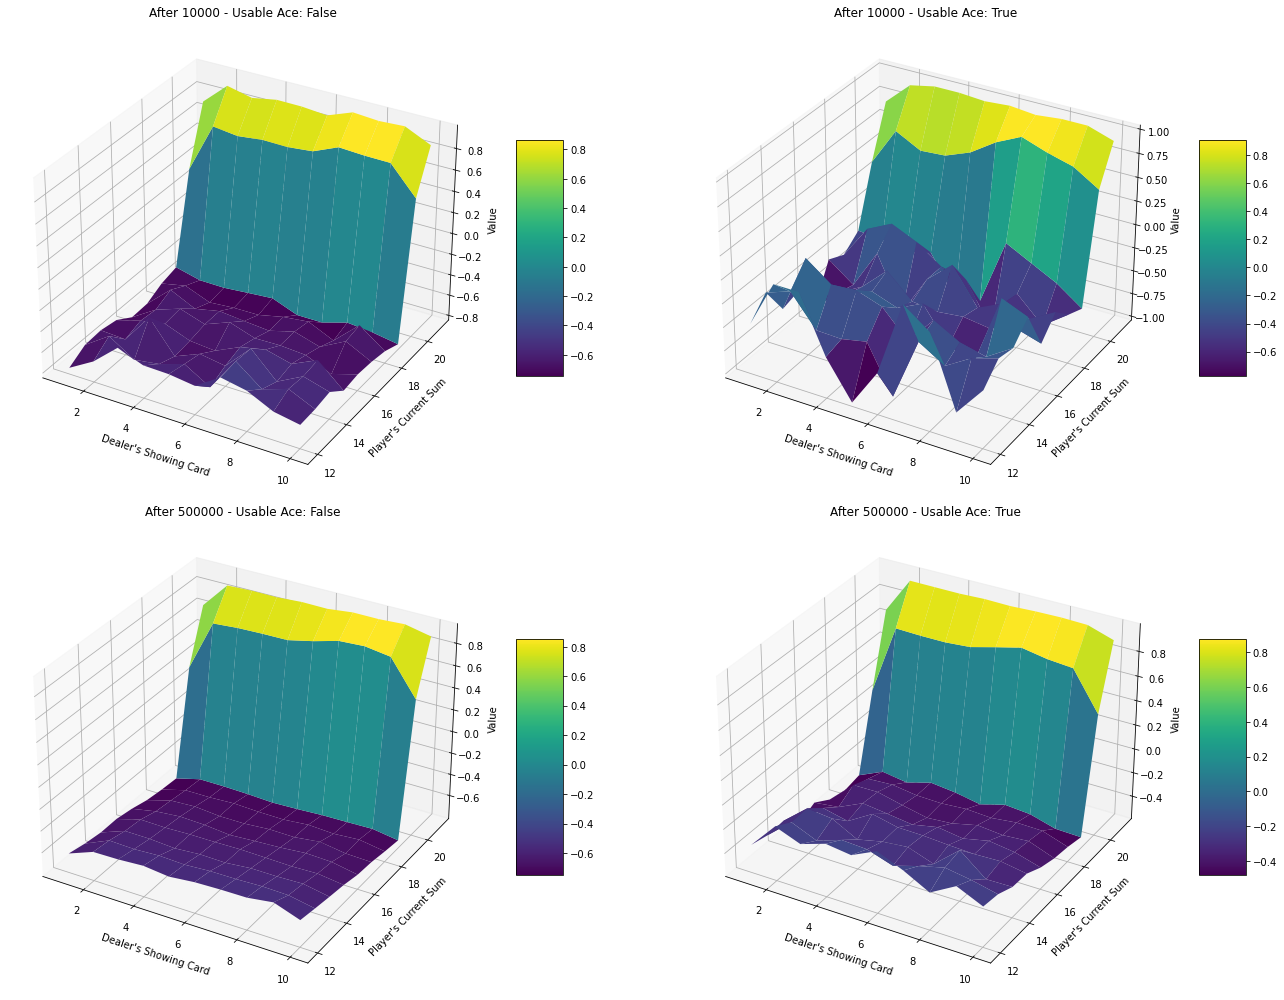

In [281]:
first_num_episodes = 10_000
second_num_episodes = 500_000

# Generate Figure 5.1 from Sutton & Barto's book.
V_first = first_visit_monte_carlo(env, sab_policy, num_episodes=first_num_episodes)
V_second = first_visit_monte_carlo(env, sab_policy, num_episodes=second_num_episodes)

plot_value_function_subplot(V_first, V_second, f'After {first_num_episodes}', f'After {second_num_episodes}')

In [282]:
# Monte Carlo ES (Exploring Starts), for estimating $π = π_*$.
def monte_carlo_es(env, num_episodes=5000, gamma=1.0):
    """
    Performs Monte Carlo with Exploring Starts (MC-ES) for policy estimation.

    This function estimates an optimal policy π ≈ π* for a given environment by
    exploring starting state-action pairs randomly and updating the policy based
    on the returns received. It uses the First-Visit MC method for each state-action
    pair encountered in each episode.

    Parameters:
        env (gym.Env): The environment to train the policy against, which should follow
                       the OpenAI Gym interface and include a 'state_space' and an 'action_space'.
        num_episodes (int): The number of episodes to run the Monte Carlo ES algorithm for. Defaults to 5000.
        gamma (float): The discount factor used to calculate the return of an episode.
                       It must be a value between 0 and 1, where 1 considers future rewards
                       as important as immediate rewards, and 0 considers only immediate rewards.

    Returns:
        pi (dict): A dictionary mapping from each state to an action, representing the
                   estimated optimal policy after the given number of episodes.

    Example:
        >>> env = CustomBlackjackEnv()
        >>> optimal_policy = monte_carlo_es(env, num_episodes=10000)
        >>> print(optimal_policy)

    Note:
        The environment must have a method `state_space` that provides a list of all possible states
        and an `action_space` that provides the number of possible actions. The `action_space` must
        also have a `sample()` method for random action selection.
    """

    # Get the total number of states - this will be used below to randomly
    # select an index to pick a random state.
    num_states = len(env.state_space)

    # Initialize the Q-table: (s, a) -> random Real number for each (s, a) tuple.
    Q = {
        (state, action) : np.random.rand()
        for state in env.state_space
        for action in range(env.action_space.n)
    }

    # Initialize the policy to be random.
    policy = TabularPolicy([0, 1], env.state_space)

    # Initialize the Returns: (s, a) -> empty list for each (s, a) tuple.
    R = {
        (state, action) : []
        for state in env.state_space
        for action in range(env.action_space.n)
    }

    # For each episode...
    for _ in range(num_episodes):

        # Choose random state and action with equal probability.
        state_index = np.random.choice(range(num_states))
        state, action = env.state_space[state_index], env.action_space.sample()

        # Generate an episode following the current policy.
        episode = generate_episode(env, policy, starting_state=state, starting_action=action)
        episode.reverse()

        # Initialize the return.
        G = 0

        # Unpack the episode into tuples.
        states, actions, rewards = zip(*episode)

        # Get the terminal time step T.
        T = len(states)

        # For each step t in T-1, T-2, ..., 2, 1, 0 in the episode.
        for t in range(T-1, -1, -1):

            # G <- gamma * G + R_{t+1}
            G = gamma * G + rewards[t]

            # Check that S_t is not in S_0, S_1, ..., S_{t-1}.
            if (states[t], actions[t]) not in zip(states[:t], actions[:t]):

                # Append to the list of returns for the state-action tuple (S_t, A_t).
                # These returns will be used to calculate the average return for that state-action pair.
                R[(states[t], actions[t])].append(G)

                # Update the Q-value for (S_t, A_t); that is, Q(S_t, A_t) <- average of the returns.
                # Note, this could be more efficiently following the same pattern as with the Bandit
                # problem from Sutton & Barto Chapter 2.
                Q[(states[t], actions[t])] = np.mean(R[(states[t], actions[t])])

                # Update the policy to be greedy with respect to Q.
                policy.policy_function = lambda input_state : np.argmax([Q[input_state, a] for a in range(env.action_space.n)])
    return policy

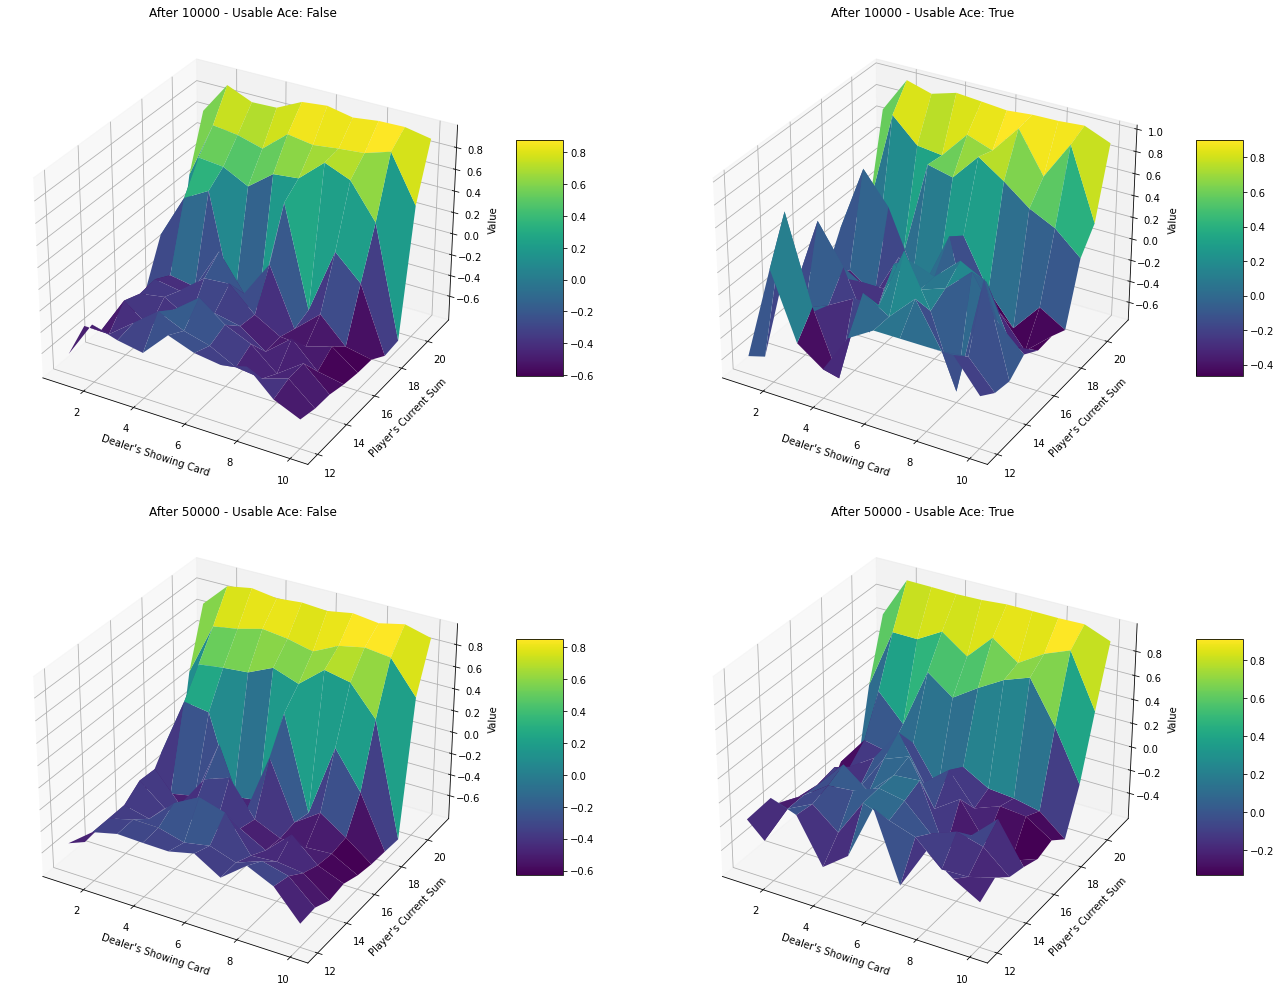

In [283]:
first_num_episodes = 10_000
second_num_episodes = 50_000
# Compute a better than guessing policy using Monte Carlo Exploring Starts.
pi = monte_carlo_es(env, num_episodes=50_000)

# Generate Figure 5.1 from Sutton & Barto's book.
V_first = first_visit_monte_carlo(env, pi, num_episodes=first_num_episodes)
V_second = first_visit_monte_carlo(env, pi, num_episodes=second_num_episodes)

plot_value_function_subplot(V_first, V_second, f'After {first_num_episodes}', f'After {second_num_episodes}')

In [256]:
print("-"*80)
random_win_percentage = win_percentage(env, random_policy)
# Percentage of wins.
print(f'Random Policy Win Percentage: {random_win_percentage}%')

print("-"*80)
sab_win_percentage = win_percentage(env, sab_policy)
# Percentage of wins.
print(f'Sutton & Barto Policy Win Percentage: {sab_win_percentage}%')

print("-"*80)
pi = monte_carlo_es(env, num_episodes=50_000)
monte_carlo_es_win_percentage = win_percentage(env, pi)
# Percentage of wins.
print(f'Monte Carlo ES Policy Win Percentage: {monte_carlo_es_win_percentage}%')
print("-"*80)

--------------------------------------------------------------------------------
Random Policy Win Percentage: 19.91%
--------------------------------------------------------------------------------
Sutton & Barto Policy Win Percentage: 11.85%
--------------------------------------------------------------------------------
Monte Carlo ES Policy Win Percentage: 16.45%
--------------------------------------------------------------------------------


----

## Monte Carlo Control without Exploring Starts 

**Question.** How can we avoid the unlikely assumption of exploring starts? (That all actions are selected infinitely often)

**Solutions.** On-policy methods and off-policy methods.... 

### On-Policy Methods
On-policy methods attempt to evaluate or to improve the policy that is being used to make decisions, whereas off-policy methods evaluate or improve a policy different from the one used to generate the data; with Monte Carlo methods the data here are the episodes generated by the policy. The Monte Carlo ES method above is considered a on-policy method, but we now discuss a on-policy method  which does not assume anything about exploring starts. Off-policy methods are considered in the next section. 

* On-policy control methods typically have *soft policies*, meaning that $\pi(a, s) > 0$ for all $s \in \mathcal{S}$ and all $a \in \mathcal{A}(s)$. 

The most popular soft policies are the *$\epsilon$-greedy* policies, meaning that most of the time they choose an action that has a maximal estimated action value, but with probability $\epsilon$ they instead select an action at random (recall such policies from the Bandits problem covered in Sutton & Barto Chapter 2). 

* ($\implies$) All nongreedy actions are given the minimal probability of selection $\frac{\epsilon}{|\mathcal{A}(s)|}$. 

* ($\implies$) The remaining greedy action is given the remaining buld probability of $1 - \epsilon + \frac{\epsilon}{|\mathcal{A}(s)|}$. 

Find the code implementing **on-policy first-visit Monte Carlo control (for $\epsilon$-soft policies), estimates for $\pi \approx \pi_{*}$** in the following code cell.

----

In [284]:
# On-policy first-visit Monte Carlo Control( for epsilon-soft policies), for estimating $\pi \approx \pi_*$.
def on_policy_first_visit_monte_carlo(env, env_actions, num_episodes=5000, gamma=1.0, epsilon=0.025):
    """
    Performs on-policy first-visit Monte Carlo Control to estimate an epsilon-soft policy
    that approximates the optimal policy π ≈ π* for a given environment.

    This function iteratively generates episodes using the current policy, updates the action-value
    function Q based on the returns following first visits to state-action pairs, and then updates
    the policy towards an epsilon-greedy policy derived from Q.

    Parameters:
        env (gym.Env): The environment in which to estimate the policy. It should define `state_space`
                       that lists all possible states and `action_space` that specifies the possible actions.
        env_actions (list): A list of possible actions in the environment. This is used to ensure compatibility
                            with environments that do not explicitly provide an action space.
        num_episodes (int): The number of episodes to run for estimating the policy. Defaults to 5,000.
        gamma (float): The discount factor, specifying the importance of future rewards. It must be a value
                       between 0 and 1, inclusive.
        epsilon (float): The parameter determining the degree of exploration in the epsilon-soft policy. A higher
                         value leads to more exploration.

    Returns:
        TabularPolicy: An instance of the TabularPolicy class representing the estimated policy after
                       num_episodes of training. The policy is epsilon-soft, meaning it mostly selects the
                       best action according to the Q-values but occasionally explores other actions.

    Example:
        >>> env = gym.make('Blackjack-v0')
        >>> env_actions = [0, 1]  # Assuming binary actions: stick or hit
        >>> estimated_policy = on_policy_first_visit_monte_carlo(env, env_actions)
        >>> print(estimated_policy.policy_table)

    Note:
        - This implementation updates the policy to be epsilon-greedy with respect to the Q-values after each episode.
        - The policy starts with equal probabilities for all actions in each state and gradually shifts towards favoring
          actions with higher expected returns, while still ensuring some level of exploration as dictated by epsilon.
        - The function also prints the percentage of states visited during training, providing insight into the
          exploration coverage.
    """
    # Initialize the policy to be random.
    initial_policy_table = {state: np.ones(len(env_actions))/len(env_actions) for state in env.state_space}
    policy = TabularPolicy(env_actions, env.state_space, policy_table=initial_policy_table)

    # Initialize the Q-table: (s, a) -> random Real number for each (s, a) tuple.
    Q = {
        (state, action) : np.random.rand()
        for state in env.state_space
        for action in range(env.action_space.n)
    }

    # Initialize the Returns: (s, a) -> empty list for each (s, a) tuple.
    R = {
        (state, action) : []
        for state in env.state_space
        for action in range(env.action_space.n)
    }

    visited_states = set()
    # For each episode...
    for _ in range(num_episodes):

        # Generate an episode following the current policy.
        episode = generate_episode(env, policy)
        episode.reverse()

        # Initialize the return.
        G = 0

        # Unpack the episode into tuples.
        states, actions, rewards = zip(*episode)

        # Get the terminal time step T.
        T = len(states)


        # For each step t in T-1, T-2, ..., 2, 1, 0 in the episode.
        for t in range(T-1, -1, -1):
            visited_states.add(states[t])

            # G <- R_{t+1} + gamma * G
            # (note: this is the same as the Bandit problem from Sutton & Barto Chapter 2)
            G = rewards[t] + gamma * G

            # Check that S_t is not in S_0, S_1, ..., S_{t-1}.
            if not (states[t], actions[t]) in zip(states[:t], actions[:t]):
                # Append to the list of the expected returns following the current policy after
                # visiting the state-action pair (S_t, A_t).
                R[(states[t], actions[t])].append(G)

                # The Q-value for the state-action tuple (S_t, A_t) is the expected return following that state-action pair
                # following the current policy. Note, this could be more efficiently following the same pattern as with the Bandit
                # problem from Sutton & Barto Chapter 2.
                Q[(states[t], actions[t])] = np.mean(R[(states[t], actions[t])])

                # Update the epsilon-soft policy.
                A_star = np.argmax([Q[(states[t], a)] for a in env_actions])
                probabilities = []
                for action in env_actions:
                    if action == A_star:
                        probabilities.append(1.0 - epsilon + (epsilon / len(env_actions)))
                    else:
                        probabilities.append(epsilon / len(env_actions))
                policy.policy_table[states[t]] = probabilities
    # Print the percentage of states visited.
    print(f'Percentage of states visited: {len(visited_states)/len(env.state_space) * 100}%')
    return policy

--------------------------------------------------------------------------------
Random Policy Win Percentage: 18.95%
--------------------------------------------------------------------------------
Sutton & Barto Policy Win Percentage: 12.13%
--------------------------------------------------------------------------------
Monte Carlo ES Policy Win Percentage: 18.34%
--------------------------------------------------------------------------------
Percentage of states visited: 46.666666666666664%
Monte Carlo Soft-Policy Win Percentage: 24.33%
--------------------------------------------------------------------------------



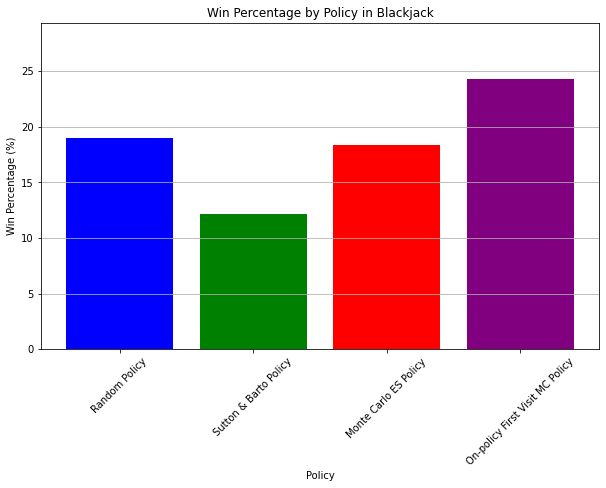

In [285]:
print("-"*80)
random_win_percentage = win_percentage(env, random_policy)
# Percentage of wins.
print(f'Random Policy Win Percentage: {random_win_percentage}%')

print("-"*80)
sab_win_percentage = win_percentage(env, sab_policy)
# Percentage of wins.
print(f'Sutton & Barto Policy Win Percentage: {sab_win_percentage}%')

print("-"*80)
pi = monte_carlo_es(env, num_episodes=100_000)
monte_carlo_es_win_percentage = win_percentage(env, pi)
# Percentage of wins.
print(f'Monte Carlo ES Policy Win Percentage: {monte_carlo_es_win_percentage}%')
print("-"*80)

# Compute a policy using On-policy First Visit Monte Carlo.
pi = on_policy_first_visit_monte_carlo(env, [0, 1], num_episodes=100_000, epsilon=0.025)
monte_carlo_soft_policy_win_percentage = win_percentage(env, pi)
# Percentage of wins.
print(f'Monte Carlo Soft-Policy Win Percentage: {monte_carlo_soft_policy_win_percentage}%')
print("-"*80)
print()

win_percentages = {
    "Random Policy": random_win_percentage,
    "Sutton & Barto Policy": sab_win_percentage ,
    "Monte Carlo ES Policy": monte_carlo_es_win_percentage,
    "On-policy First Visit MC Policy": monte_carlo_soft_policy_win_percentage
}

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(win_percentages.keys(), win_percentages.values(), color=['blue', 'green', 'red', 'purple'])

plt.xlabel('Policy')
plt.ylabel('Win Percentage (%)')
plt.title('Win Percentage by Policy in Blackjack')
plt.xticks(rotation=45)
plt.ylim(0, max(win_percentages.values()) + 5)  # Set y-axis limit a bit higher for better visual
plt.grid(axis='y')

# Display the bar graph
plt.show()
